# Election results by District

When visualizing the voting records of representatives in the US House of Representatives it will be useful to have some idea not just of the party that the representatives belongs to, but also the degree of partisan lean that might be expected from the representative. To get some data on this one approach is simply to allocate a partisan lean based on the relative margin of victory in their district -- the larger the relative margin of victory the more partisan we might expect the representative to be. Because we are simply using this data to assign colors to representatives in a visualization we will be rather imprecise. If you want to use this data for any quantitative purposes a lot more care and a lot less corner cutting will be required. We can access this data via records of elections kept at Harvard.

In [7]:
!wget -q -O "1976-2018-house.csv" https://dataverse.harvard.edu/api/access/datafile/3814252?gbrecs=false

The next step is to process this data -- which is rather more extensive and detailed that we require -- into something relatively simple that records the relative partisan lean of each representative based on their election results each election. We can use pandas for this data wrangling.

In [2]:
import pandas as pd

First let's just load the csv file that we downloaded and see what it contains.

In [99]:
election_data = pd.read_csv("1976-2018-house.csv", sep="\t")

In [100]:
election_data.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,runoff,special,candidate,party,writein,mode,candidatevotes,totalvotes,unofficial,version
0,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,Bill Davenport,democrat,False,total,58906,157170,False,20200424
1,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,Jack Edwards,republican,False,total,98257,157170,False,20200424
2,1976,Alabama,AL,1,63,41,US House,1,gen,False,False,NaN,NaN,True,total,7,157170,False,20200424
3,1976,Alabama,AL,1,63,41,US House,2,gen,False,False,J. Carole Keahey,democrat,False,total,66288,156362,False,20200424
4,1976,Alabama,AL,1,63,41,US House,2,gen,False,False,NaN,NaN,True,total,5,156362,False,20200424


The first thing that needs to be dealt with is the fact that candidates potentially belonged to multiple parties over the entire electoral career. This is not just a case of switching between Republican and Democrat, but actually much more commonly moving between a smaller party such as Libertarian, Green, etc. and Republican or Democrat. While keeping track of all of this is potentially useful, for the purposes of the visualizations we wish to protray it will be much simpler if we just align each candidate to the party that they belonged to for most of the elections they participated in. In theory this is as simple as assigning each candidate to the most common party. In practice we have to handle odd corner cases like equal splits between parties (largely for lesser known / unelected candidates).

In [76]:
unique_party_mapping = election_data.groupby('candidate').party.agg(pd.Series.mode).to_dict()
for k, v in unique_party_mapping.items():
    if type(v) != str:
        if len(v) > 1:
            unique_party_mapping[k] = v[0]
        else:
             unique_party_mapping[k] = "N/A"

We can now set a single unique party affiliation for each candidate -- which will suffice for the level of analysis we are doing.

In [78]:
election_data["party"] = election_data.candidate.map(unique_party_mapping)

Now we need to determine the margin of victory and assign a partisan lean score for each candidate that won. That means we need to create a function that, given a dataframe of all the candidates and relults for *a single election and district*, can return the winning candidate and a score as to their partisan lean. Again there are all manner of corner cases that can arise, but since our use of this data is fairly simple and limited we will prune things down and ignore most of the odd cases -- for example we'll reduce everything to just Republican and Democrat for simplicity. For a partisan lean score we will produce a value between 0 and 1 with 0 representing a 100% Republican, and 1 representing 100% Democrat.

In [91]:
def winner_and_party_ratio(df):
    winner = df[df.candidatevotes == df.candidatevotes.max()]
    winning_party = winner.party.values
    losing_party = "republican" if winning_party == "democrat" else "democrat"
    loser = df[df.party == losing_party]
    winner_votes = winner.candidatevotes.values
    loser_votes = loser.candidatevotes.values.sum() if len(loser) > 0 else 0
    if winning_party == "republican" or winning_party == "conservative":
        ratio = 1.0 - (winner_votes / (winner_votes + loser_votes))
    else:
        ratio = (winner_votes / (winner_votes + loser_votes))
    
    return pd.DataFrame({"year": winner.year.values, "state": winner.state_po.values, "district": winner.district.values, 
                         "winner": winner.candidate.values, "party": winner.party.values, "winning_ratio": ratio})

Now we can process the data by using a groupby to select out the individual elections (year, state and district) and using our function to convert each sub-dataframe into a single result giving data on the winner of each election.

In [92]:
result = []
for key, df in election_data[election_data.stage == "gen"].groupby(["year", "state_po", "district"]):
    result.append(winner_and_party_ratio(df))
election_winners = pd.concat(result)

<ipython-input-91-f34cb21952ef>:11: RuntimeWarning: invalid value encountered in true_divide
  ratio = (winner_votes / (winner_votes + loser_votes))


We can check that the resulting dataframe has the sort of information we expect.

In [93]:
election_winners.head()

,year,state,district,winner,party,winning_ratio
0,1976,AK,0,Don Young,republican,0.289986
0,1976,AL,1,Jack Edwards,republican,0.374808
0,1976,AL,2,"William L. \\""Bill\""\"" Dickinson""",republican,0.423953
0,1976,AL,3,Bill Nichols,democrat,1.000000
0,1976,AL,4,Tom Bevill,democrat,0.803825


The result in Alabama with a score of 1.0 stands out -- that would be a 100% vote margin for thw winner -- which seems odd. A little research turns up the fact that the candidate was running (essentially) unopposed in that district, so our simplistic calculation of the Republican / Democrat vote share gave this as a result. Again, if you are using this for quantitative purposes you will want to be more careful, but for generating colors for a plot this will suffice for now.

We can check on the distribution of values to see how often this sort of thing happens though:

In [94]:
import seaborn as sns

<AxesSubplot:xlabel='winning_ratio'>

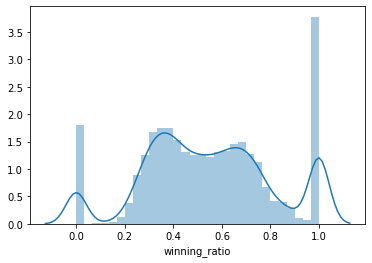

In [95]:
sns.distplot(election_winners.winning_ratio)

Not great, but good enough for the purposes to which we wish to put this data. We can save it off far later use.

In [96]:
election_winners.to_csv('election_winners_1976-2018.csv')